In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [4]:
image_path="D:/CVR_MINI_PROG/archive (1)/images/images/train"

train_path="D:/CVR_MINI_PROG/archive (1)/images/images/train"
valid_path="D:/CVR_MINI_PROG/archive (1)/images/images/validation"

In [5]:
class_names = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))]

In [6]:
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
number_of_images = {}
for class_name in class_names:
    number_of_images[class_name] = len(os.listdir(image_path+"/"+class_name))

images_per_class = pd.DataFrame(list(number_of_images.items()), columns=['Class Name', 'Number of Images'])
images_per_class

,Class Name,Number of Images
0,angry,3993
1,disgust,436
2,fear,4103
3,happy,7164
4,neutral,4982
5,sad,4938
6,surprise,3205


In [8]:
# Training data generator with data augmentation
traindata_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (rescaling only)
validdata_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# Training data
train_generator = traindata_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation data
validation_generator = validdata_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [10]:
# Define Class Names
class_names = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]
print("Class Names:", class_names)

Class Names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [11]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
mobilenetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [13]:
for layer in mobilenetV2_model.layers:
    layer.trainable = False
    
# Adding custom layers on top of the base model
x = mobilenetV2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
prediction = Dense(7, activation='softmax')(x)

In [14]:
model = Model(inputs=mobilenetV2_model.input, outputs=prediction)

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,100,167 (15.64 MB)

 Trainable params: 1,841,159 (7.02 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [18]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


c:\Users\anshs\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 490s 532ms/step - accuracy: 0.3452 - loss: 1.7777 - val_accuracy: 0.3971 - val_loss: 1.7005 - learning_rate: 0.0010
Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 440s 487ms/step - accuracy: 0.4121 - loss: 1.5335 - val_accuracy: 0.4086 - val_loss: 1.5326 - learning_rate: 0.0010
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 454s 502ms/step - accuracy: 0.4290 - loss: 1.4872 - val_accuracy: 0.4335 - val_loss: 1.5001 - learning_rate: 0.0010
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 441s 488ms/step - accuracy: 0.4331 - loss: 1.4709 - val_accuracy: 0.4418 - val_loss: 1.4431 - learning_rate: 0.0010
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 462s 512ms/step - accuracy: 0.4452 - loss: 1.4467 - val_accuracy: 0.4247 - val_loss: 1.5251 - learning_rate: 0.0010
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 444s 492ms/step - accuracy: 0.4357 - loss: 1.4537 - val_accuracy: 0.4457 - val_loss: 1.5065 - learning_rate: 0.0010
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 453s 501ms/step - accuracy: 0.4506 

In [19]:
for layer in mobilenetV2_model.layers:
    layer.trainable = True

In [20]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1805s 2s/step - accuracy: 0.3032 - loss: 1.8236 - val_accuracy: 0.4169 - val_loss: 1.5811 - learning_rate: 1.0000e-05
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 2889s 3s/step - accuracy: 0.4286 - loss: 1.4973 - val_accuracy: 0.4260 - val_loss: 1.4907 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 2028s 2s/step - accuracy: 0.4720 - loss: 1.3810 - val_accuracy: 0.4387 - val_loss: 1.4483 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1878s 2s/step - accuracy: 0.5009 - loss: 1.3045 - val_accuracy: 0.4633 - val_loss: 1.3862 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1792s 2s/step - accuracy: 0.5231 - loss: 1.2532 - val_accuracy: 0.4982 - val_loss: 1.3179 - learning_rate: 1.0000e-05
Epoch 6/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1870s 2s/step - accuracy: 0.5483 - loss: 1.2114 - val_accuracy: 0.5386 - val_loss: 1.2338 - learning_rate: 1.0000e-05
Epoch 7/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1730s 2s/ste

In [22]:
fine_tune_history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1736s 2s/step - accuracy: 0.6018 - loss: 1.0607 - val_accuracy: 0.6032 - val_loss: 1.0641 - learning_rate: 1.0000e-05
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1729s 2s/step - accuracy: 0.6089 - loss: 1.0408 - val_accuracy: 0.6094 - val_loss: 1.0448 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1725s 2s/step - accuracy: 0.6176 - loss: 1.0110 - val_accuracy: 0.6189 - val_loss: 1.0292 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1723s 2s/step - accuracy: 0.6237 - loss: 1.0006 - val_accuracy: 0.6179 - val_loss: 1.0160 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1724s 2s/step - accuracy: 0.6301 - loss: 0.9768 - val_accuracy: 0.6257 - val_loss: 1.0037 - learning_rate: 1.0000e-05
Epoch 6/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1727s 2s/step - accuracy: 0.6392 - loss: 0.9719 - val_accuracy: 0.6311 - val_loss: 0.9936 - learning_rate: 1.0000e-05
Epoch 7/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1728s 2s/ste

In [32]:
fine_tune_history3 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 2131s 2s/step - accuracy: 0.6699 - loss: 0.8865 - val_accuracy: 0.6427 - val_loss: 0.9684 - learning_rate: 1.0000e-05
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1767s 2s/step - accuracy: 0.6717 - loss: 0.8784 - val_accuracy: 0.6417 - val_loss: 0.9681 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1739s 2s/step - accuracy: 0.6808 - loss: 0.8499 - val_accuracy: 0.6504 - val_loss: 0.9610 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1853s 2s/step - accuracy: 0.6859 - loss: 0.8423 - val_accuracy: 0.6494 - val_loss: 0.9680 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 32489s 36s/step - accuracy: 0.6962 - loss: 0.8162 - val_accuracy: 0.6476 - val_loss: 0.9651 - learning_rate: 1.0000e-05
Epoch 6/10
398/901 ━━━━━━━━━━━━━━━━━━━━ 16:39 2s/step - accuracy: 0.7012 - loss: 0.8089

KeyboardInterrupt: 

In [34]:
final_train_accuracy = fine_tune_history2.history['accuracy'][-1]
final_val_accuracy = fine_tune_history2.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

Final Training Accuracy: 66.04%
Final Validation Accuracy: 64.00%


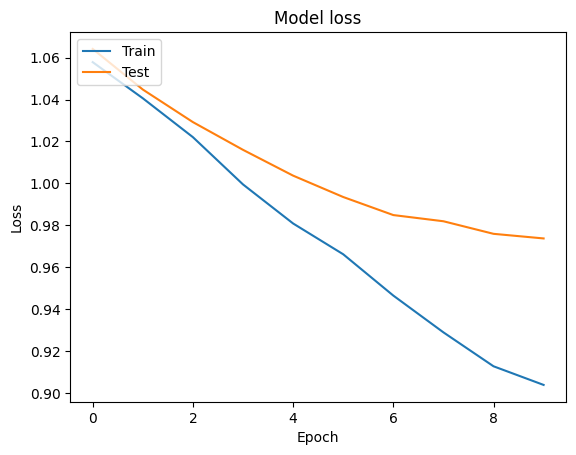

In [38]:
plt.plot(fine_tune_history2.history['loss'])
plt.plot(fine_tune_history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

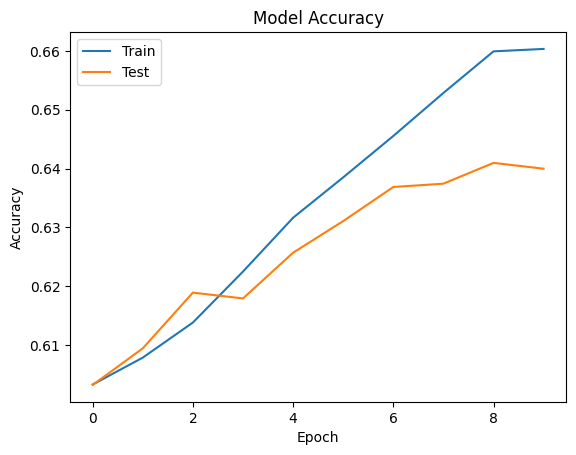

In [39]:
plt.plot(fine_tune_history2.history['accuracy'])
plt.plot(fine_tune_history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [44]:
true_classes = validation_generator.classes
predicted_classes = np.argmax(model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size))), axis=1)
class_labels = list(validation_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

AttributeError: 'History' object has no attribute 'predict'

In [42]:
print(cm)

[[105   7  88 275 215 181  89]
 [ 11   1  13  34  23  17  12]
 [123   7 122 246 222 193 105]
 [201  17 188 513 404 321 181]
 [149  13 127 323 240 221 143]
 [144   7 141 275 247 207 118]
 [103   3  88 221 140 137 105]]


In [48]:
# Convert the model architecture to JSON
model_json = model.to_json()

# Save the model architecture as a JSON file
with open("expression_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved to model_architecture.json")


Model architecture saved to model_architecture.json


In [49]:
# Save only the model weights with the correct filename
model.save_weights("expressions.weights.h5")

print("Model weights saved to expressions.weights.h5")



Model weights saved to expressions.weights.h5


In [51]:
import pickle
# Save the training history using Pickle
with open("training_history.pkl", "wb") as f:
    pickle.dump(fine_tune_history2.history, f)

print("Training history saved as a Pickle file: training_history.pkl")


Training history saved as a Pickle file: training_history.pkl
